In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
sys.path.append('../')

In [17]:
# Charger les données
listings = pd.read_csv('/Users/mathisgorvien/DEV/datathon-2024/Data/cleaned/Data_15_Decembre_2023/listings_detailed_cleaned/part-00000-181d8edb-59f4-45cb-9889-7a7aa91b7725-c000.csv/part-00000-31bd41c7-49d1-49ba-8719-b171f466d5a9-c000.csv')

# Fonction pour calculer la distance Haversine
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcule la distance entre deux points géographiques (en km).
    """
    R = 6371  # Rayon moyen de la Terre en kilomètres
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Différence des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Formule de Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Exemple : Calculer la distance entre deux logements
lat1, lon1 = listings.loc[0, ['latitude', 'longitude']]
lat2, lon2 = listings.loc[1, ['latitude', 'longitude']]

distance = haversine(lat1, lon1, lat2, lon2)
print(f"Distance entre les deux logements : {distance:.2f} km")

# Appliquer sur tout le DataFrame
# Exemple pour calculer les distances à partir d'un point de référence
reference_lat, reference_lon = 45.764043, 4.835659  # Exemple : coordonnées de Lyon
listings['distance_from_reference'] = listings.apply(
    lambda row: haversine(reference_lat, reference_lon, row['latitude'], row['longitude']), axis=1
)

# Afficher les distances
print(listings[['id', 'name', 'latitude', 'longitude', 'distance_from_reference']].head())

Distance entre les deux logements : 1.88 km
         id                                               name  latitude  \
0   2009737  Rental unit in Lyon · ★4.73 · 1 bedroom · 1 be...  45.77358   
1   9287664   Rental unit in Lyon · 1 bedroom · 1 bed · 1 bath  45.75675   
2   9343326   Rental unit in Lyon · 1 bedroom · 1 bed · 1 bath  45.74254   
3  16254715   Rental unit in Lyon · 1 bedroom · 1 bed · 1 bath  45.76941   
4  18380070  Rental unit in Lyon · ★4.72 · 2 bedrooms · 3 b...  45.76660   

   longitude  distance_from_reference  
0   4.827844                 1.221486  
1   4.829780                 0.930393  
2   4.870070                 3.583982  
3   4.834980                 0.599103  
4   4.829750                 0.539382  


,Profile Category,Count,Avg Price,Median Price,Avg Distance from Center
0,Autre (Centre-ville),6350,99.647402,70.0,1.453107
1,Autre (Périphérie),1404,73.042023,56.0,3.858945
2,Maison familiale (Centre-ville),2064,177.585756,140.0,1.424262
3,Maison familiale (Périphérie),411,156.352798,118.0,3.817888


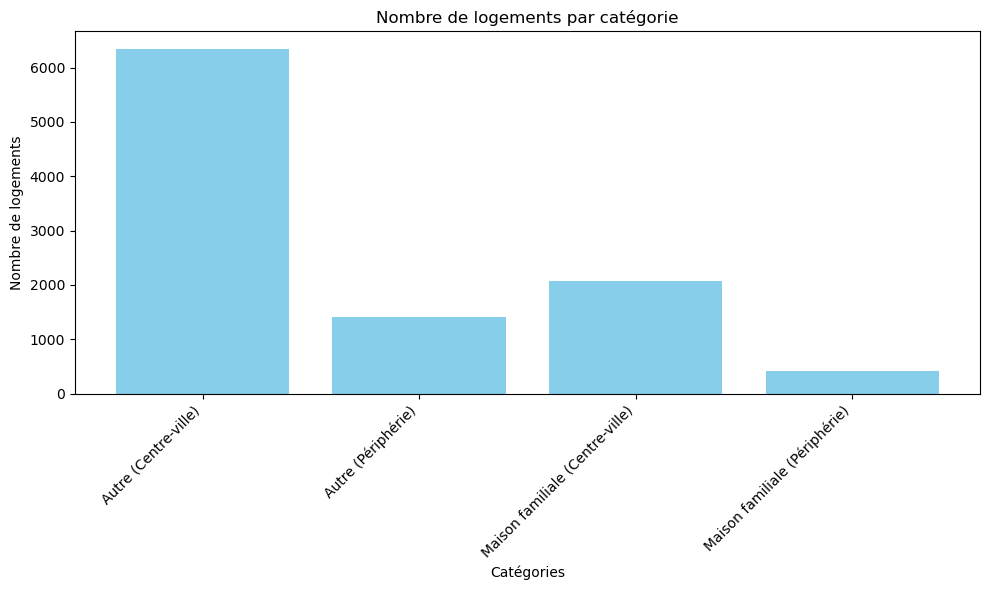

In [21]:
# Nettoyer la colonne 'price' pour supprimer les symboles de devise ou autres caractères non numériques
listings['price'] = listings['price'].replace('[^\d.]', '', regex=True).astype(float)

# Ajouter une colonne 'distance_from_center' si ce n'est pas déjà fait
reference_lat, reference_lon = 45.764043, 4.835659  # Coordonnées du centre de Lyon
listings['distance_from_center'] = listings.apply(
    lambda row: haversine(reference_lat, reference_lon, row['latitude'], row['longitude']), axis=1
)

# Catégorisation des logements
def categorize_listing(row):
    if row['distance_from_center'] <= 3:  # Rayon de 3 km pour définir le centre-ville
        location = 'Centre-ville'
    else:
        location = 'Périphérie'

    if 'Studio' in row['property_type']:
        category = 'Studio'
    elif row['accommodates'] >= 4 and row['bedrooms'] >= 2:
        category = 'Maison familiale'
    else:
        category = 'Autre'

    return f"{category} ({location})"

# Ajouter une colonne avec la catégorie
listings['profile_category'] = listings.apply(categorize_listing, axis=1)

# Filtrer les profils bien renseignés
listings_rich = listings.dropna(subset=['property_type', 'room_type', 'bedrooms', 'accommodates'])

# Regrouper par catégories pour caractériser les profils
profile_summary = listings_rich.groupby('profile_category').agg({
    'id': 'count',
    'price': ['mean', 'median'],
    'distance_from_center': 'mean'
}).reset_index()

# Renommer les colonnes
profile_summary.columns = ['Profile Category', 'Count', 'Avg Price', 'Median Price', 'Avg Distance from Center']

# Afficher le tableau dans un notebook
from IPython.display import display
display(profile_summary)

# Visualisation avec matplotlib
plt.figure(figsize=(10, 6))
plt.bar(profile_summary['Profile Category'], profile_summary['Count'], color='skyblue')
plt.title("Nombre de logements par catégorie")
plt.xlabel("Catégories")
plt.ylabel("Nombre de logements")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [22]:
import folium

# Créer une carte centrée à Lyon
m = folium.Map(location=[45.764043, 4.835659], zoom_start=12)

# Ajouter des marqueurs
for _, row in listings.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"{row['name']} ({row['distance_from_reference']:.2f} km)",
    ).add_to(m)

# Afficher la carte
m.save("map_airbnb.html")


#  Analyses exploratoires

## Corrélation entre prix et quartier :

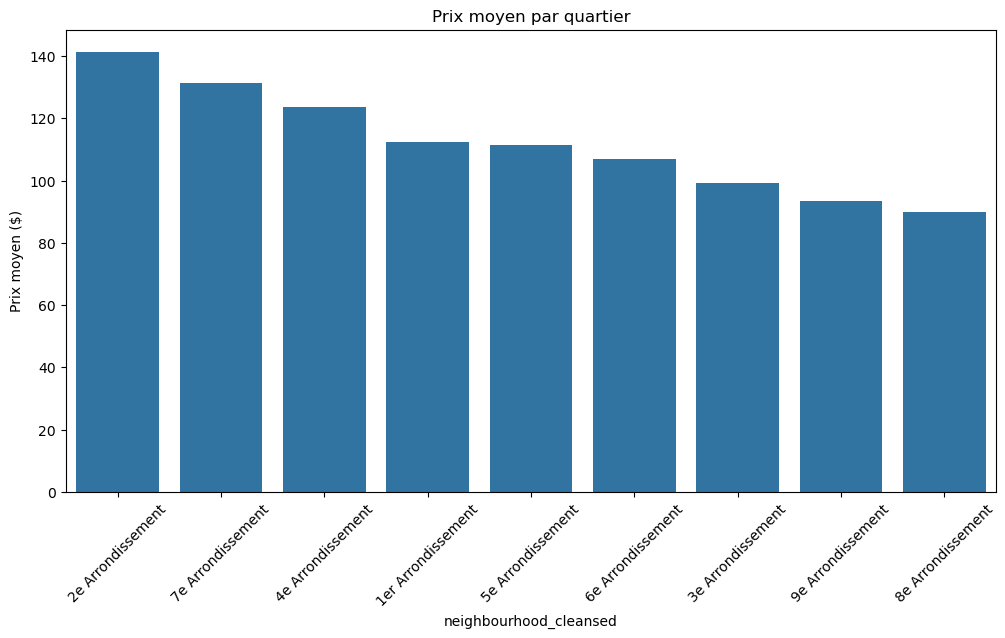

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prix moyen par quartier
price_per_neighbourhood = listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=price_per_neighbourhood.index, y=price_per_neighbourhood.values)
plt.title('Prix moyen par quartier')
plt.xticks(rotation=45)
plt.ylabel('Prix moyen ($)')
plt.show()

## Corrélation entre prix et quartier :

                  availability_365
availability_365               1.0


<Axes: >

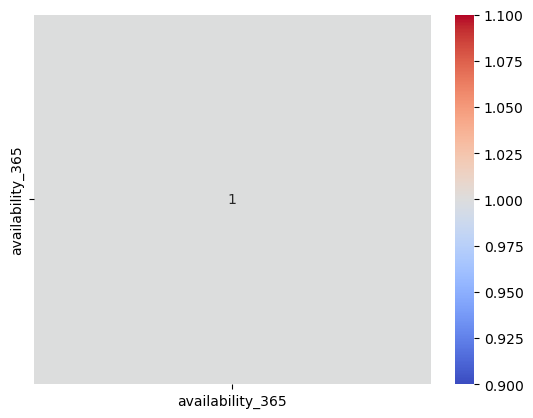

In [ ]:
corr = listings[['availability_365', 'review_scores_rating']].corr()
print(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Calculs avancés

## Revenus potentiels annuels
- Basé sur le prix moyen par nuit et la disponibilité annuelle.

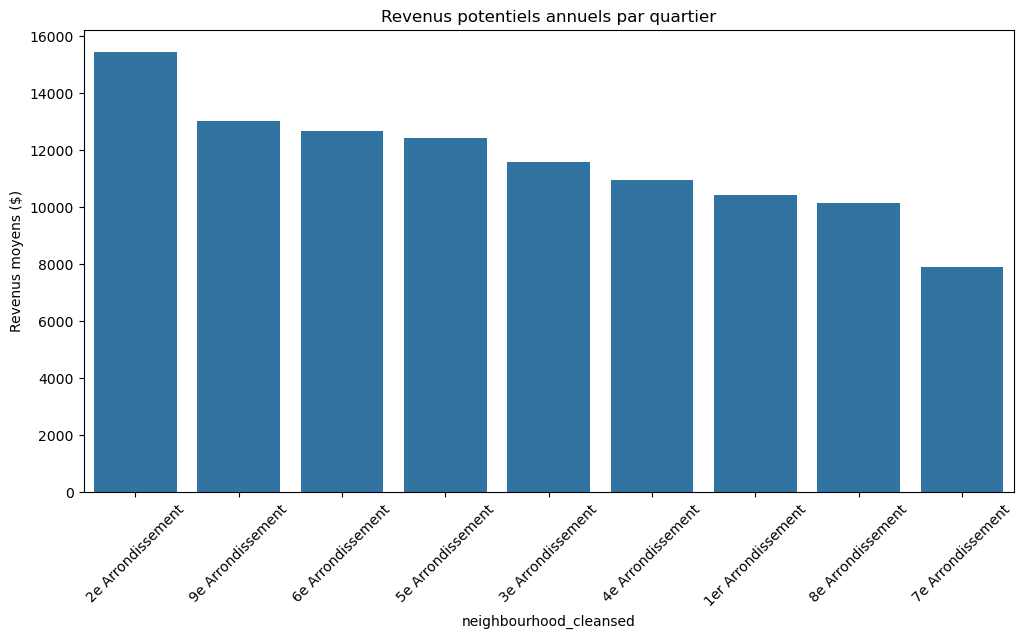

In [29]:
listings['potential_revenue'] = listings['price'] * listings['availability_365']
revenue_per_neighbourhood = listings.groupby('neighbourhood_cleansed')['potential_revenue'].mean().sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=revenue_per_neighbourhood.index, y=revenue_per_neighbourhood.values)
plt.title('Revenus potentiels annuels par quartier')
plt.xticks(rotation=45)
plt.ylabel('Revenus moyens ($)')
plt.show()


## Taux d’occupation
- Avec les données du calendrier (calendar.csv) :

In [32]:
# Charger les données
calendar = pd.read_csv('/Users/mathisgorvien/DEV/datathon-2024/Data/cleaned/Data_23_March_2024/calendar_cleaned/part-00000-b698dc00-279c-432c-85bd-58dbb79b4cf1-c000.csv/part-00000-6c539fb3-7f00-4c8a-9069-2413613b7bce-c000.csv')

In [33]:
# Ajouter une colonne pour indiquer si la propriété est occupée ou disponible
calendar['is_available'] = calendar['available'].apply(lambda x: 1 if x == 't' else 0)

# Calculer le taux d'occupation
occupancy_rate = calendar.groupby('listing_id')['is_available'].mean()
listings = listings.merge(occupancy_rate, left_on='id', right_index=True, how='left')
listings.rename(columns={'is_available': 'occupancy_rate'}, inplace=True)


## Analyse des notes des hôtes
- Identifiez les hôtes les mieux notés.

In [35]:
top_hosts = listings.groupby('host_id')['review_scores_rating'].mean().sort_values(ascending=False).head(10)
print(top_hosts)

KeyError: 'Column not found: review_scores_rating'

# Caractérisation des profils
**Clustering des profils :** Utilisez KMeans pour regrouper automatiquement les propriétaires en profils similaires.

         accommodates  availability_365   latitude  longitude       price
profile                                                                  
0            2.787640         24.903077  45.767862   4.828799   94.754424
1            2.956084        299.544831  45.760719   4.838234  114.372827
2            6.737828         68.031835  45.761260   4.836385  293.335206
3            2.733798         35.243186  45.747858   4.855476   77.158086


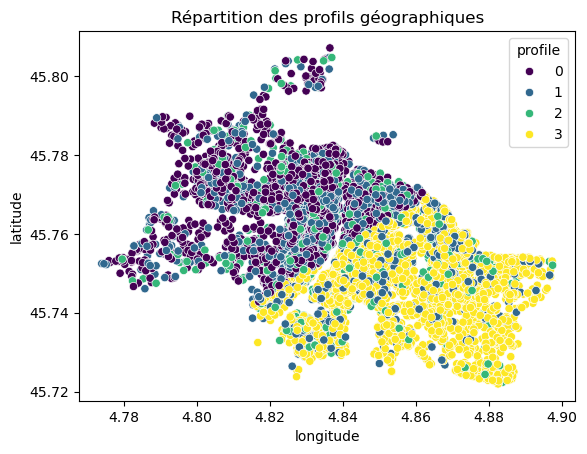

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Variables pertinentes pour le clustering
features = ['accommodates', 'availability_365', 'latitude', 'longitude', 'price']
data = listings[features].dropna()  # Retirer les lignes avec NaN

# Normalisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Ajuster n_clusters si nécessaire
data['cluster'] = kmeans.fit_predict(data_scaled)

# Associer les clusters au dataset principal
listings['profile'] = data['cluster']

# S'assurer que `profile` est bien numérique
listings['profile'] = pd.to_numeric(listings['profile'], errors='coerce')

# Agrégation par cluster
profiles = listings.groupby('profile')[features].mean()
print(profiles)

# Visualisation des clusters
sns.scatterplot(
    x=listings['longitude'], 
    y=listings['latitude'], 
    hue=listings['profile'], 
    palette='viridis'
)
plt.title("Répartition des profils géographiques")
plt.show()

Statistiques descriptives par profil :

In [38]:
profiles = listings.groupby('profile').agg({
    'price': ['mean', 'median'],
    'accommodates': 'mean',
    'availability_365': 'mean'
}).reset_index()
print(profiles)

  profile       price        accommodates availability_365
                 mean median         mean             mean
0       0   94.754424   75.0     2.787640        24.903077
1       1  114.372827   85.0     2.956084       299.544831
2       2  293.335206  166.5     6.737828        68.031835
3       3   77.158086   62.0     2.733798        35.243186
